In [4]:
!pip install transformers==2
import torch
import pickle
from torch import nn
import numpy as np
import pandas as pd
from transformers import *
from sklearn.metrics import roc_curve, auc
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader, random_split

In [5]:
class InputExample(object):
    def __init__(self, id, text, labels=None):
        self.id = id
        self.text = text
        self.labels = labels

class InputFeatures(object):
    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [6]:
def get_train_examples(train_file):
    train_df = pd.read_csv(train_file)
    ids = train_df['id'].values
    text = train_df['comment_text'].values
    labels = train_df[train_df.columns[2:]].values
    examples = []
    for i in range(len(train_df)):
        examples.append(InputExample(ids[i], text[i], labels=labels[i]))
    return examples

In [7]:
def get_features_from_examples(examples, max_seq_len, tokenizer):
    features = []
    for i,example in enumerate(examples):
        tokens = tokenizer.tokenize(example.text)
        if len(tokens) > max_seq_len - 2:
            tokens = tokens[:(max_seq_len - 2)]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)
        segment_ids = [0] * len(tokens)
        padding = [0] * (max_seq_len - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        assert len(input_ids) == max_seq_len
        assert len(input_mask) == max_seq_len
        assert len(segment_ids) == max_seq_len
        label_ids = [float(label) for label in example.labels]
        features.append(InputFeatures(input_ids=input_ids,
                                      input_mask=input_mask,
                                      segment_ids=segment_ids,
                                      label_ids=label_ids))
    return features

In [8]:
def get_dataset_from_features(features):
    input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.float)
    dataset = TensorDataset(input_ids,
                            input_mask,
                            segment_ids,
                            label_ids)
    return dataset

In [9]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, dropout=0.1, kernel_num=3, kernel_sizes=[2,3,4], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.embed = nn.Embedding(self.embed_num, self.embed_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)
        
    def forward(self, inputs, labels=None):
        output = inputs.unsqueeze(1)
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs]
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output]
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits

In [11]:
device = torch.device(type='cuda')
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
basemodel = BertModel.from_pretrained(pretrained_weights)
basemodel.to(device)

100%|██████████| 440473133/440473133 [00:12<00:00, 36535342.11B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [12]:
seq_len = 256
train_file = '../input/bertdataset/train.csv'
train_examples = get_train_examples(train_file)
train_features = get_features_from_examples(train_examples, seq_len, tokenizer)
train_dataset = get_dataset_from_features(train_features)


train_val_split = 0.1
train_size = int(len(train_dataset)*(1-train_val_split))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

batch = 8
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch)

In [13]:
embed_num = seq_len 
embed_dim = basemodel.config.hidden_size 
dropout = basemodel.config.hidden_dropout_prob
kernel_num = 3
kernel_sizes = [2,3,4]
num_labels = 6

model = KimCNN(embed_num, embed_dim, dropout=dropout, kernel_num=kernel_num, kernel_sizes=kernel_sizes, num_labels=num_labels)
model.to(device)

KimCNN(
  (embed): Embedding(256, 768)
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=9, out_features=6, bias=True)
)

In [2]:
print("MD")

MD


In [23]:
print('ROC AUC per label:')
    for label in labels:
        print(label, ': ', roc_auc[label])

IndentationError: unexpected indent (<ipython-input-23-d4d9e3fe0f88>, line 2)

In [13]:
lr = 3e-5
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i in range(epochs):
    print('-----------EPOCH #{}-----------'.format(i+1))
    print('training...')
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        with torch.no_grad():
            inputs,_ = basemodel(input_ids, segment_ids, input_mask)
        loss = model(inputs, label_ids)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    y_true = []
    y_pred = []
    
    model.eval()
    print('evaluating...')
    for step, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        val_input_ids, val_input_mask, val_segment_ids, val_label_ids = batch
        with torch.no_grad():
            val_inputs,_ = basemodel(val_input_ids, val_segment_ids, val_input_mask)
            logits = model(val_inputs)
        y_true.append(val_label_ids)
        y_pred.append(logits)

    y_true = torch.cat(y_true, dim=0).float().cpu().detach().numpy()
    y_pred = torch.cat(y_pred, dim=0).float().cpu().detach().numpy()
    
# checkpoint = {'model': KimCNN(),
#               'state_dict': model.state_dict(),
#               'optimizer' : optimizer.state_dict()}




-----------EPOCH #1-----------
training...
evaluating...


TypeError: __init__() missing 2 required positional arguments: 'embed_num' and 'embed_dim'

In [17]:
y_true = []
y_pred = []

model = torch.load('../input/bertmodel/bert_cnn_clf.pth')
model.eval()
print('evaluating...')
for step, batch in enumerate(val_dataloader):
    batch = tuple(t.to(device) for t in batch)
    val_input_ids, val_input_mask, val_segment_ids, val_label_ids = batch
    with torch.no_grad():
        val_inputs,_ = basemodel(val_input_ids, val_segment_ids, val_input_mask)
        logits = model(val_inputs)
    y_true.append(val_label_ids)
    y_pred.append(logits)

y_true = torch.cat(y_true, dim=0).float().cpu().detach().numpy()
y_pred = torch.cat(y_pred, dim=0).float().cpu().detach().numpy()

evaluating...


In [59]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

# print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
# print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
# print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

# print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
# print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
# print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

# print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
# print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
# print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [47]:
print(y_true.shape)
print(pred.shape)

(15958, 6)
(15958,)


In [19]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fpr = dict()
tpr = dict()
roc_auc = dict()

for i,label in enumerate(labels):
    fpr[label], tpr[label], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

print('ROC AUC per label:')
for label in labels:
    print(label, ': ', roc_auc[label])

ROC AUC per label:
toxic :  0.9704702636427738
severe_toxic :  0.9719392195281402
obscene :  0.978180238372994
threat :  0.8507324882607653
insult :  0.9650843744577478
identity_hate :  0.9448492976812383


In [83]:
for i in n_classes:
    print(i)

TypeError: 'int' object is not iterable

(1830,)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


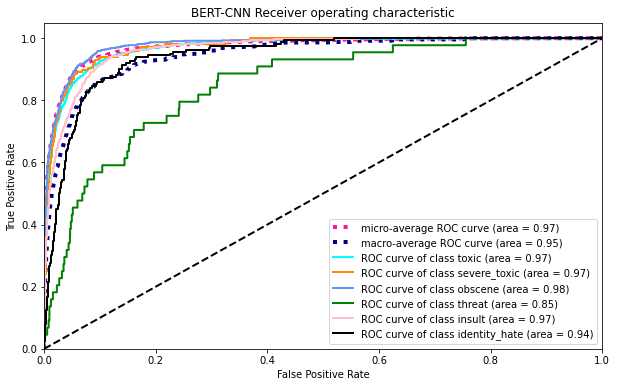

<Figure size 216x720 with 0 Axes>

In [105]:
from scipy import interp
from itertools import cycle


n_classes = len(labels)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in labels]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in labels:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'pink', 'black'])
for i, color in zip(labels, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT-CNN Receiver operating characteristic')
plt.legend(loc="lower right")
plt.figure(figsize=(3, 10))
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


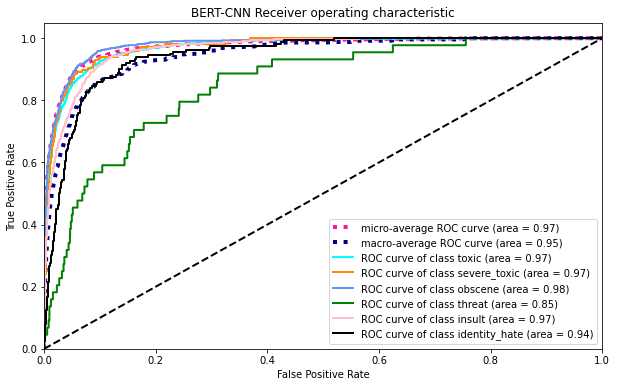

<Figure size 216x720 with 0 Axes>

In [67]:
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
tokenizer.decode(val_dataset[0][0])

'[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UN

In [63]:
val_dataset[0][0]

tensor([  101,  2298,  1010,  2004,  1045,  1005,  2310,  2525,  4541,  1010,
         2045,  2003,  2053,  2862,  1012,  2045,  1005,  1055,  2069,  1037,
         2862,  1997,  2035,  2831,  5530,  7013,  2013,  1996,  3972, 20624,
         2239,  8833,  1012,  1037,  2235,  7099,  1010,  2320,  2153,  1024,
         2324,  1024,  4413,  2340,  1013,  2676,  8247,  9006,  2386,  2094,
         1006, 26203,  3972, 20624,  2239,  2104,  1045,  2581,  1007,  2324,
         1024,  4413,  2340,  1013,  2676,  8247,  9006,  2386,  2094,  1006,
        26203,  3972, 20624,  2239,  2104,  1045,  2581,  1007,  2324,  1024,
         4413,  2340,  1013,  2676,  8247,  9006,  2386,  2094,  1006, 26203,
         3972, 20624,  2239,  2104,  1045,  2581,  1007,  2324,  1024,  4413,
         2340,  1013,  2676,  8247,  9006,  2386,  2094,  1006, 26203,  3972,
        20624,  2239,  2104,  1045,  2581,  1007,  2324,  1024,  4413,  2340,
         1013,  2676,  6583, 13668,  2378,  9148,  3211,  1006, 

In [71]:
print(y_true[:, 0])
print(sigmoid(y_pred[:, 0]))
temp = sigmoid(y_pred[:, 0])
np.argmax(temp, axis=0)

[0. 0. 0. ... 0. 1. 0.]
[0.0089335  0.11722498 0.10517326 ... 0.00801701 0.82066035 0.02799987]


6978

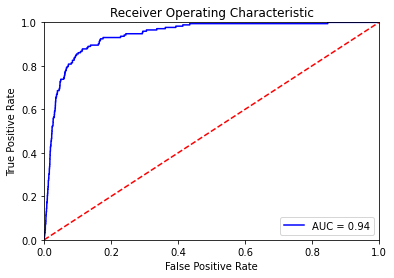

In [52]:
fp,tp, _ = roc_curve(y_test, pred)
roc_auc = auc(fp, tp)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fp, tp, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [140]:
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, make_scorer, fbeta_score, multilabel_confusion_matrix,\
    average_precision_score, precision_score, recall_score
y_results = {}
y_results["Data"] = []
y_results["F1 Samples"] = []
y_results["F1 Macro"] = []
y_results["F1 Micro"] = []
y_results["Pr Samples"] = []
y_results["Pr Macro"] = []
y_results["Pr Micro"] = []
y_results["Re Samples"] = []
y_results["Re Macro"] = []
y_results["Re Micro"] = []
y_results["Accuracy"] = []
y_results["Hamming"] = []

def results(y_t, y_p, y_results, name):
    thr = 0.374
    y_pr = []
    for i in y_p:
        temp_y = []
        cou = 0
        for j in i:
            if j > thr:
                temp_y.append(1)
            else:
                temp_y.append(0)
            cou = cou + 1
        y_pr.append(temp_y)
    y_p = np.array(y_pr)
    y_results["Data"].append(name)
    y_results["F1 Samples"].append(f1_score(y_t, y_p, average='samples'))
    y_results["F1 Macro"].append(f1_score(y_t, y_p, average='macro'))
    y_results["F1 Micro"].append(f1_score(y_t, y_p, average='micro'))
    y_results["Pr Samples"].append(
        precision_score(y_t, y_p, average='samples'))
    y_results["Pr Macro"].append(precision_score(y_t, y_p, average='macro'))
    y_results["Pr Micro"].append(precision_score(y_t, y_p, average='micro'))
    y_results["Re Samples"].append(recall_score(y_t, y_p, average='samples'))
    y_results["Re Macro"].append(recall_score(y_t, y_p, average='macro'))
    y_results["Re Micro"].append(recall_score(y_t, y_p, average='micro'))
    y_results["Accuracy"].append(accuracy_score(y_t, y_p))
    y_results["Hamming"].append(hamming_loss(y_t, y_p))
    return y_results, y_p

y_pred_bin = sigmoid(y_pred)
y_results, y_p = results(y_true, y_pred_bin, y_results, 'Valid')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetr

In [141]:
print(y_p.flatten().shape)
print(y_true.flatten().shape)

(95748,)
(95748,)


In [142]:
accuracy_score(y_true, y_p)

0.9068178969795714

In [137]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_p))

              precision    recall  f1-score   support

           0       0.50      0.93      0.65      1581
           1       0.32      0.65      0.42       167
           2       0.48      0.89      0.62       847
           3       0.00      0.00      0.00        44
           4       0.40      0.85      0.54       816
           5       0.17      0.43      0.25       162

   micro avg       0.44      0.86      0.58      3617
   macro avg       0.31      0.62      0.41      3617
weighted avg       0.44      0.86      0.58      3617
 samples avg       0.07      0.09      0.07      3617



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
for k, v in y_results.items():
    print("{}\t{}".format(k+'      ', v[0]))
        

Data      	Valid
F1 Samples      	0.05519782086707766
F1 Macro      	0.3836963758801493
F1 Micro      	0.6584703816062589
Pr Samples      	0.06294961774658478
Pr Macro      	0.5405637383316657
Pr Micro      	0.7792894935752078
Re Samples      	0.054451267911601285
Re Macro      	0.32906319254548494
Re Micro      	0.5700857063865081
Accuracy      	0.9068178969795714
Hamming      	0.022339892217069807


In [40]:
sigmoid(y_pred)

array([[8.9335041e-03, 7.9703331e-04, 3.0158714e-03, 8.1607647e-04,
        4.4273040e-03, 7.3496043e-04],
       [1.1722498e-01, 2.7339035e-03, 2.6606362e-02, 4.7588701e-04,
        1.1295457e-02, 3.3557601e-03],
       [1.0517326e-01, 1.6167413e-02, 5.2168682e-02, 1.2452479e-02,
        1.0908793e-01, 1.2889742e-02],
       ...,
       [8.0170128e-03, 4.4896267e-04, 2.5258271e-03, 6.4728013e-04,
        4.3869498e-03, 4.3242713e-04],
       [8.2066035e-01, 3.3449735e-02, 4.2548522e-01, 3.5179416e-03,
        2.8888842e-01, 4.1039225e-02],
       [2.7999870e-02, 7.8183673e-03, 1.5320304e-02, 2.4870515e-03,
        1.9771446e-02, 4.8762388e-03]], dtype=float32)

In [31]:
y_results

{'Data': ['Valid'],
 'F1 Samples': [0.03892017140231202],
 'F1 Macro': [0.2722293934554529],
 'F1 Micro': [0.5411582413325586],
 'Pr Samples': [0.051040230605339014],
 'Pr Macro': [0.4503005988217679],
 'Pr Micro': [0.9036222509702458],
 'Re Samples': [0.034462338638927184],
 'Re Macro': [0.19994564630259817],
 'Re Micro': [0.3862316837157866],
 'Accuracy': [0.9048126331620504],
 'Hamming': [0.024742031165141832]}

In [21]:
def sigmoid(z):
    s = 1.0 / (1.0 + np.exp(-1.0 * z))
    return s



In [35]:
tokenizer.decode(val_dataset[0][0])

'[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UN

In [22]:
for i in np.random.randint(0, len(y_pred), size=10):
    string = tokenizer.decode(val_dataset[i][0], skip_special_tokens=True)
    print('---------------------------------')
    print('Comment:')
    print(string)
    preds = dict(zip(labels, sigmoid(y_pred[i])))
    print('Prediction:')
    for label in preds:
        print(label, ': ', preds[label])

---------------------------------
Comment:
[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
Prediction:
toxic :  0.0129416585
severe_toxic :  0.00058386475
obscene :  0.0070850104
threat :  0.0008652898
insult :  0.00954784
identity_hate :  0.0008484744
---------------------------------
Comment:
[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [U

---------------------------------
Comment:
Mainly to JTD ( i think ) - I've just scanned through this discussion stuff having read the article. My initial impression was that this was going very kindly on the British indeed. It is admitted at some point in the discussion that there is a move among Irish historians away from previous over - simplifications of the matter - but isn't this move itself perhpas reactionary? I mean, Irish historians of this or any generation speak for their times, and, for lay readers like myself, the CONTEXT of this estimation of the role of the British imperial adventure in the famine is lost to those who have not studied so carefully the history of the history of the famine. This is, afterall, a general encyclopedia. So please twist the screws a bit. I won't go editing the article, but some feedback would be appreciated in this regard, Basically, you're all better historians than myself, but maybe some of your nuances are therefore misplaced here, ( a bit less d'Alembert and more Diderot as it were ) Cheers, Simon

Prediction:

toxic :  0.009333727

severe_toxic :  0.00015343125

obscene :  0.020101553

threat :  0.00029461284

insult :  0.0016380053

identity_hate :  0.0008575509

---------------------------------
Comment:
Need some guidance I need to report another user for attempting to intimidate me by violating my privacy by calling out personal details about my location on my user talk page. His user name is Hasteur. Can you please direct me to the right place?

Prediction:

toxic :  0.0068807625

severe_toxic :  0.00023090332

obscene :  0.0145177

threat :  0.00049068616

insult :  0.005037717

identity_hate :  0.0010609339

---------------------------------

Comment:
I'm afraid not. I think you need to ask somebody who's an administrator on Commons. ( I'm an admin on en. wiki, not on Commons. ) — Talk / Stalk

Prediction:

toxic :  0.017199917

severe_toxic :  0.0008454597

obscene :  0.025758682

threat :  0.002444282

insult :  0.008249491

identity_hate :  0.0033726753

---------------------------------
Comment:
Hey useless troll, you just don't get tired enough of being stomped again and again, right?

Prediction:

toxic :  0.7409974

severe_toxic :  0.098911814

obscene :  0.21756598

threat :  0.007269864

insult :  0.27900904

identity_hate :  0.04931407

